In [15]:
from MakeBallBounceSetup import MakeManipulationStation, CreateControllerPlant
# Imports
import numpy as np
import altair as alt
import pydot
import matplotlib.pyplot as plt
from IPython.display import display, SVG, clear_output
import plotly.express as px
import matplotlib.patches as mpatches

from pydrake.all import (
    AddMultibodyPlantSceneGraph, AngleAxis, BasicVector, 
    DiagramBuilder, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
    LeafSystem, MeshcatVisualizerCpp, MultibodyPlant, MultibodyPositionToGeometryPose, Parser,
    PiecewisePose, PiecewisePolynomial, Quaternion, RigidTransform, 
    RollPitchYaw, RotationMatrix, SceneGraph, Simulator, TrajectorySource,sin,cos,Solve,
    AddContactMaterial,CoulombFriction,AddRigidHydroelasticProperties,ProximityProperties,AddSoftHydroelasticProperties,Sphere,
    SpatialInertia,UnitInertia,SpatialVelocity
)
from pydrake.multibody import inverse_kinematics
from pydrake.examples.manipulation_station import ManipulationStation
from BounceHelper import Optimizer2d, PseudoInverseController

from manipulation.meshcat_cpp_utils import (
    StartMeshcat, AddMeshcatTriad)
from manipulation.scenarios import AddMultibodyTriad, SetColor

# TODO(russt): Move this to drake (adding the element name support to the base class).
import pandas as pd
def dataframe(trajectory, times, names):
  assert trajectory.rows() == len(names)
  values = trajectory.vector_values(times)
  data = {'t': times }
  for i in range(len(names)):
    data[names[i]] = values[i,:]
  return pd.DataFrame(data)

In [16]:
meshcat = StartMeshcat()

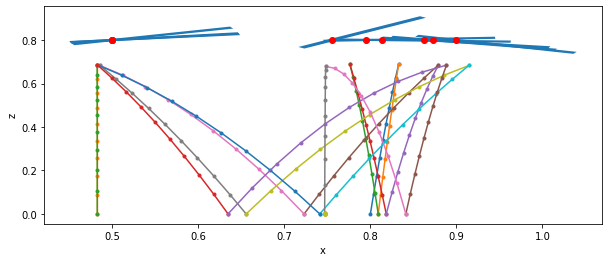

In [34]:
N=10
g=9.81
h,q_m,q_mdot,q_b,q_bdot = Optimizer2d(N,e=.8,initialV = 5)

#Plot the solution
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel('x')
ax.set_ylabel('z')

relative_time = np.linspace(0, 1, 10)

x_start=q_b[0,0]
z_start=0
for i in range(N):
    t = h[0,i]*relative_time
    x = x_start+ q_bdot[0,i]*t
    z = z_start + q_bdot[1,i]*t - .5*g*t*t
    ax.plot(x, z, '.-')
    x_start = x[-1]
    z_start = z[-1]

    if i is not N-1:
        t = h[1,i]*relative_time
        x = x_start+ q_mdot[3,i]*t
        z = z_start + q_mdot[4,i]*t - .5*g*t*t
        x_m = q_m[0,i]
        y_m = q_m[1,i]
        theta_m = q_m[2,i]

       
        Normal = np.array([sin(theta_m),-cos(theta_m)])
        tangent =  np.array([cos(theta_m),sin(theta_m)])

        pos = [x_m,y_m] + Normal*.005 - tangent*0.05
        
        ax.plot(x, z, '.-')
        ax.plot(x_m,y_m,'ro')
        tangent = np.array([])
     
        ax.add_patch(mpatches.Rectangle(pos,.2,.01,angle=theta_m*180/np.pi))
        x_start = x[-1]
        z_start = z[-1]

times = np.cumsum(np.sum(h,axis=0))


In [35]:
#Inverse Kinematics Controller

q0 =  [0, np.pi/3+.1, 0, -np.pi/2, 0, -np.pi/3, 0]


def create_q_knots(pose_lst):
  """Convert end-effector pose list to joint position list using series of
  InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
  contain gripper joints, but these should not matter to the constraints.
  @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
  @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
  """
  q_knots = []
  plant = CreateControllerPlant()
 
  q_nominal = np.array([ 0., 0.6, 0., -1.75, 0., 1., 0.]) # nominal joint for joint-centering.


  defaultContext = plant.CreateDefaultContext()
  plant.SetPositions(defaultContext, plant.GetModelInstanceByName("iiwa7"),q0)
  world_frame = plant.world_frame()
  gripper_frame = plant.GetFrameByName("base_link")

  def AddOrientationConstraint(ik, R_WG, bounds):
    """Add orientation constraint to the ik problem. Implements an inequality
    constraint where the axis-angle difference between f_R(q) and R_WG must be
    within bounds. Can be translated to:
    ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
    """
    ik.AddOrientationConstraint(
        frameAbar=world_frame, R_AbarA=R_WG,
        frameBbar=gripper_frame, R_BbarB=RotationMatrix(),
        theta_bound=bounds
    )

  def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
    """Add position constraint to the ik problem. Implements an inequality
    constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
    translated to
    ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
    """
    ik.AddPositionConstraint(
        frameA=world_frame, frameB=gripper_frame, p_BQ=np.zeros(3),
        p_AQ_lower=p_WG_lower, p_AQ_upper=p_WG_upper)

  for i in range(len(pose_lst)):
    ik = inverse_kinematics.InverseKinematics(plant)
    q_variables = ik.q() # Get variables for MathematicalProgram
    #print(q_variables)
    prog = ik.prog() # Get MathematicalProgram

    #### Modify here ###############################
    if i == 0:
      prog.SetInitialGuess(q_variables,q_nominal)
    else:
      prog.SetInitialGuess(q_variables,q_knots[i-1])

    X_WG = pose_lst[i]


    prog.AddQuadraticErrorCost(.1*np.identity(len(q_nominal)),q_nominal, q_variables)
    
    y_slack = np.array([0.005,.1,.005],float)

    p = X_WG.translation()
    r = X_WG.rotation()



    p1 = p-(y_slack)
    p2 = p+(y_slack)
    AddPositionConstraint(ik,p1,p2)

    AddOrientationConstraint(ik,r,0)

    #AddMeshcatTriad(meshcat,path=str(1),X_PT=RigidTransform(p1),radius=.25)
    #AddMeshcatTriad(meshcat,path=str(2),X_PT=RigidTransform(p2),radius=.25)


    ################################################
  
    result = Solve(prog)

    if not result.is_success():
      print(i)
      infesible = result.GetInfeasibleConstraints(prog)
      print("Infeasible Constraints:")
      for i in range(len(infesible)):
          print(infesible[i])
      raise RuntimeError
      
    q_knots.append(result.GetSolution(q_variables))

  return q_knots





In [27]:
plant = CreateControllerPlant()

defaultContext = plant.CreateDefaultContext()
plant.SetPositions(defaultContext, plant.GetModelInstanceByName("iiwa7"), q0)

world_frame = plant.world_frame()
gripper_frame = plant.GetFrameByName("base_link")
X_G = gripper_frame.CalcPoseInWorld(defaultContext)


x = X_G.translation()
r = X_G.rotation()

rz= RollPitchYaw(r).pitch_angle()
newTheta = q_m[2,:]*-1

newTime = np.concatenate(([0],times))*1
#print(newTheta.shape)
finalQ_m = np.concatenate((q_m[0:2,:],[newTheta]),axis =0)-[[0],[.5],[0]]

propr_der= np.concatenate(([[q_m[0,0]],[q_m[1,0]+.1-.5],[q_m[2,0]]],finalQ_m),axis =1)

v_dot = np.concatenate(([[0],[0],[0]],q_mdot[0:3,:]),axis=1)

poly = PiecewisePolynomial.CubicHermite(newTime,propr_der,v_dot)

traj_v_G = poly.MakeDerivative()

In [36]:
data = dataframe(poly, np.linspace(poly.start_time(), poly.end_time(),N*40), ['x','z','theta'])


#Create a pose list
x_pos = np.column_stack((data['x'],np.zeros(np.array(data['x']).shape),data['z']))


rotations = [ RotationMatrix.MakeYRotation(theta) for theta in data['theta']]

transforms = [RigidTransform(rotation,xp) for xp,rotation in zip(x_pos, rotations)]

transforms = transforms[0:-2]
#print(transforms)
val = 0
for t in transforms:
  val = val+1
  AddMeshcatTriad(meshcat,"test/" + str(val),length = .15,radius = .006,X_PT=t)
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='theta').properties(height=80)
)



alt.VConcatChart(...)

In [37]:
#input the above pose list into the Inverse Kinematics Solver
 
q_knots = np.array(create_q_knots(transforms))
q_traj = PiecewisePolynomial.CubicShapePreserving(data['t'][0:-2],q_knots.T)


In [38]:
traj_a_G = traj_v_G.MakeDerivative()
data = dataframe(traj_v_G, np.linspace(traj_v_G.start_time(), traj_v_G.end_time()), ['x','z','theta'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='theta').properties(height=80),
)

alt.VConcatChart(...)

In [39]:
data = dataframe(traj_a_G, np.linspace(traj_a_G.start_time(), traj_a_G.end_time()), ['x','z','theta'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='theta').properties(height=80),
)

alt.VConcatChart(...)

In [41]:
class StateLinearSys(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetBodyByName("base_link").body_frame()
        self._W = plant.world_frame()

        self.q_port = self.DeclareVectorInputPort("q", BasicVector(7))
        self.v_port = self.DeclareVectorInputPort("v", BasicVector(7))

        self.DeclareVectorOutputPort("iwaa_state", BasicVector(14), 
                                     self.CalcOutput)

        
        # TODO(russt): Add missing binding
        #joint_indices = plant.GetJointIndices(self._iiwa)
        #self.position_start = plant.get_joint(joint_indices[0]).position_start()
        #self.position_end = plant.get_joint(joint_indices[-1]).position_start()
       

    def CalcOutput(self, context, output):
       
        q = self.q_port.Eval(context)
        
        v = self.v_port.Eval(context)
        
  
        output.SetFromVector(np.concatenate((q,v)))

In [45]:
v_traj = q_traj.MakeDerivative()
a_traj = v_traj.MakeDerivative()

meshcat.Delete()

builder = DiagramBuilder()
diag, plant = MakeManipulationStation(1e-5)
station = builder.AddSystem(diag)





temp_context = station.CreateDefaultContext()

#display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))
temp_plant_context = plant.GetMyContextFromRoot(temp_context)

plant.SetPositions(temp_plant_context, plant.GetModelInstanceByName("iiwa7"),q0)


q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
q_traj_system.set_name("q_traj")

v_traj_system = builder.AddSystem(TrajectorySource(v_traj))
v_traj_system.set_name("v_traj")


a_traj_system = builder.AddSystem(TrajectorySource(a_traj))
a_traj_system.set_name("a_traj")

StateSys = builder.AddSystem(StateLinearSys(plant))
StateSys.set_name("state Sys")



builder.Connect(q_traj_system.get_output_port(),
                StateSys.GetInputPort('q'))

builder.Connect(v_traj_system.get_output_port(),
                StateSys.GetInputPort('v'))

builder.Connect(StateSys.get_output_port(),station.GetInputPort('Desired State'))

builder.Connect(a_traj_system.get_output_port(),station.GetInputPort('desired_accel'))

visualizer = MeshcatVisualizerCpp.AddToBuilder(
    builder,station.GetOutputPort("geometry_query"), meshcat)

diagram = builder.Build()
diagram.set_name("Ball_Bouncer")

simulator = Simulator(diagram)

station_context = diagram.GetMyContextFromRoot(simulator.get_mutable_context())
plant_context = diagram.GetSubsystemContext(plant,station_context)


plant.SetPositions(plant_context, plant.GetModelInstanceByName("iiwa7"),q_knots[0])

plant.SetFreeBodyPose(plant_context, 
                        plant.GetBodyByName("ball_body"),
                        RigidTransform([.8, 0.0, .1-.5])) # limit is between 0.5 and 0.55
     
vel = SpatialVelocity([0,0,0],[.2,0,5])
plant.SetFreeBodySpatialVelocity(plant.GetBodyByName("ball_body"),vel,plant_context)




#visualizer.start_recording()

#AddMeshcatTriad(meshcat,"InitialPose",X_PT=X_G)
simulator.set_target_realtime_rate(.5)
simulator.AdvanceTo(.01)
##visualizer.stop_recording()
#isualizer.publish_recording()




In [46]:
simulator.AdvanceTo(poly.end_time())

KeyboardInterrupt: 